# Imaging and image modeling

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
%matplotlib inline
import cv2

In [2]:
plt.rcParams["figure.facecolor"]=(1,1,1,1)

In this notebook, we explore a few imaging related models and camera image processing operations.

## Pinhole camera model

First, we demonstrate, how 3D points are projected to a 2D image using the pinhole camera model. The points are randomly generated.

In [3]:
n=5
X = np.random.rand(n)*10-5
Y = np.random.rand(n)*10-5
Z = np.random.rand(n)*10+30

Then they are projected to the image plane that is at the distance $f$ from the pinhole.

In [4]:
f=5

In [5]:
x=f*X/Z
y=f*Y/Z

In [6]:
implane=np.array([[-1,-1,-f],
                  [-1,1,-f],
                  [1,1,-f],
                  [1,-1,-f],
                  [-1,-1,-f]])

The following figure shows how the rays coming from the 3D points intersect at the same point (pinhole) before hitting the image plane.

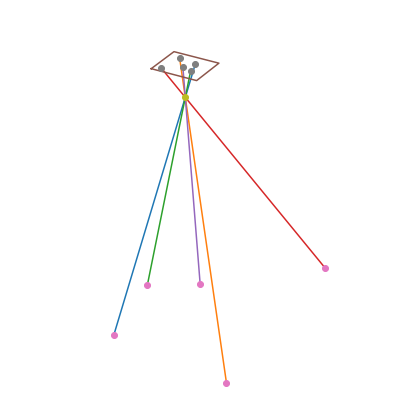

In [7]:
fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot(121, projection='3d')
for i in range(n):
    ax.plot([X[i],-x[i]],[Y[i],-y[i]],[Z[i],-f])
ax.plot(implane[:,0],implane[:,1],implane[:,2])
ax.plot(X,Y,Z,'o')
ax.plot(-x,-y,-f,'o')
ax.plot([0.0],[0.0],[0.0],'o')
#ax.view_init(0, 90)
ax.set_zlim3d(30,0)
ax.set_axis_off() 

The pinhole camera model produces images that are upside down. To avoid that it is a common practice to assume a virtual image plane that is in front of the pinhole at distance $f$ as shown in the following figure.

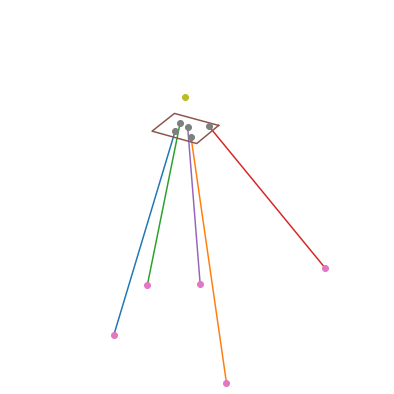

In [8]:
fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot(121, projection='3d')
for i in range(n):
    ax.plot([X[i],x[i]],[Y[i],y[i]],[Z[i],f])
ax.plot(-implane[:,0],-implane[:,1],-implane[:,2])
ax.plot(X,Y,Z,'o')
ax.plot(x,y,f,'o')
ax.plot([0.0],[0.0],[0.0],'o')
ax.set_zlim3d(30,0)
ax.set_axis_off() 

## Perspective distortion

To illustrate the effect of perspective distortion, we create a simple polygon model and visualize it from two different viewpoints. 

In [9]:
pts=[
    [0,0,0],
    [2,0,0],
    [0,1,0],
    [2,1,0],
    [0,0,1],
    [2,0,1],
    [0,1,1],
    [2,1,1],
    [0,0.5,1.5],
    [2,0.5,1.5]]

In [10]:
verts=np.array([
    [pts[0],pts[1],pts[3],pts[2],pts[0]],
    [pts[0],pts[2],pts[6],pts[4],pts[0]],
    [pts[0],pts[1],pts[5],pts[4],pts[0]],
    [pts[1],pts[3],pts[7],pts[5],pts[1]],
    [pts[2],pts[3],pts[7],pts[6],pts[2]],
    [pts[4],pts[5],pts[9],pts[8],pts[4]],
    [pts[6],pts[7],pts[9],pts[8],pts[6]],
    [pts[4],pts[6],pts[8],pts[4]],
    [pts[5],pts[7],pts[9],pts[5]]
])

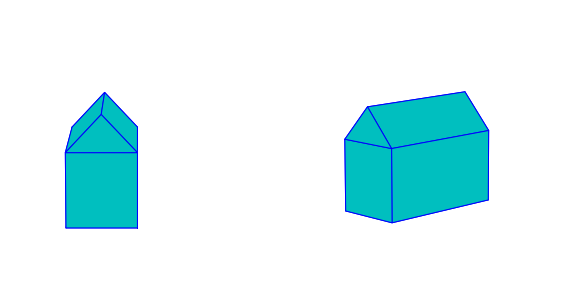

In [11]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(121, projection='3d')
ax.add_collection3d(Poly3DCollection(verts,facecolors='c',edgecolors='b'))
ax.set_xlim3d(0,2)
ax.set_ylim3d(0,2)
ax.set_zlim3d(0,2)
ax.set_axis_off() 
ax.view_init(10, 0)
ax = fig.add_subplot(122, projection='3d')
ax.add_collection3d(Poly3DCollection(verts,facecolors='c',edgecolors='b'))
ax.set_xlim3d(0,2)
ax.set_ylim3d(0,2)
ax.set_zlim3d(0,2)
ax.set_axis_off() 
ax.view_init(10, 45)

We observe that under perspective projection, lines project as lines, but angles between lines can change. Also, new details can appear because of self-occlusion.

## Lens distortion

Wide angle lenses have short focal lengths, and they are typically subject to geometric distortion. Next, we simulate lens distortion using a simple model for radial distortion with one coefficient.

In [12]:
x,y = np.meshgrid(np.arange(-1,1.01,0.01),np.arange(-1,1.01,0.01))

In [13]:
r2 = x**2 + y**2

In [14]:
k1 = -0.1

In [15]:
xb = x * (1 + k1 * r2)
yb = y * (1 + k1 * r2)

In [16]:
xp = x * (1 - k1 * r2)
yp = y * (1 - k1 * r2)

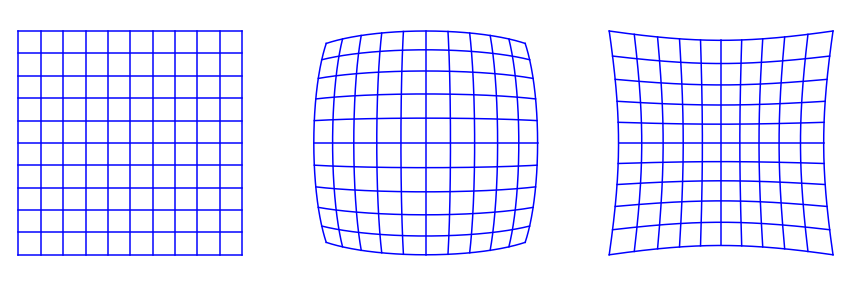

In [17]:
fig = plt.figure(figsize=(15,5))
plt.subplot(131)
for i in range(11):
    plt.plot(x[i*20,:],y[i*20,:],'b')
    plt.plot(x[:,i*20],y[:,i*20],'b')
plt.axis('equal')
plt.axis('off')
plt.subplot(132)
for i in range(11):
    plt.plot(xb[i*20,:],yb[i*20,:],'b')
    plt.plot(xb[:,i*20],yb[:,i*20],'b')
plt.axis('equal')
plt.axis('off')
plt.subplot(133)
for i in range(11):
    plt.plot(xp[i*20,:],yp[i*20,:],'b')
    plt.plot(xp[:,i*20],yp[:,i*20],'b')
plt.axis('equal')
plt.axis('off');

The first image shows a grid without distortion, the second image has barrel distortion, and the third one has pincushion distortion.

## Vignetting
Next we simulate the effect of brightness falloff towards the image boundaries using the "cosine fourth" law.

In [18]:
img = cv2.imread("images/landscape.jpg")
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

In [19]:
xi, yi = np.meshgrid(range(img.shape[1]),range(img.shape[0]))
xi = xi.astype(np.float32) - img.shape[1]/2
yi = yi.astype(np.float32) - img.shape[0]/2
di = np.sqrt(xi**2 + yi**2)

In [20]:
f = 500       #This is the focal length we assume

In [21]:
alpha = np.arctan2(di,f)

In [22]:
falloff = np.cos(alpha)**4
falloff = np.stack([falloff, falloff, falloff], axis=2)

In [23]:
vig = (img * falloff).astype(np.uint8)

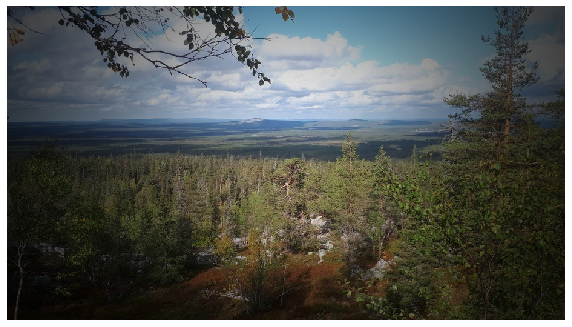

In [24]:
plt.figure(figsize=(10,10))
plt.imshow(vig)
plt.axis('off');

## Demosaicing
Here we simulate image acquisition with the Bayer color filter array (CFA) and conversion to an RGB image.

In [25]:
img = cv2.imread('images/fruits.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

This is the basic Bayer pattern.

In [26]:
bmask = np.zeros((2,2,3))
bmask[1,0,0] = 1
bmask[0,0,1] = 1
bmask[1,1,1] = 1
bmask[0,1,2] = 1

The CFA is created by repeating the pattern to cover all pixels of the image.

In [27]:
bpattern = np.kron(np.ones((int((img.shape[0]/2)), int(img.shape[1]/2), 1)), bmask).astype(np.uint8)

Here is a small part of the CFA.

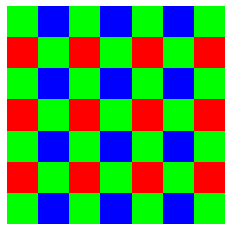

In [28]:
plt.imshow(bpattern[0:7,0:7]*255)
plt.axis('off');

Next we filter the image to simulate the output of the image sensor.

In [29]:
bayer = img * bpattern
bayer = np.sum(bayer, axis = 2)

Notice that the result has only one channel. Then, we use the color transformation from OpenCV to perform demosaicing (converting the filtered image to an RGB image with three channels).

In [30]:
debayer = cv2.cvtColor(bayer.astype(np.uint8),cv2.COLOR_BAYER_GR2RGB)

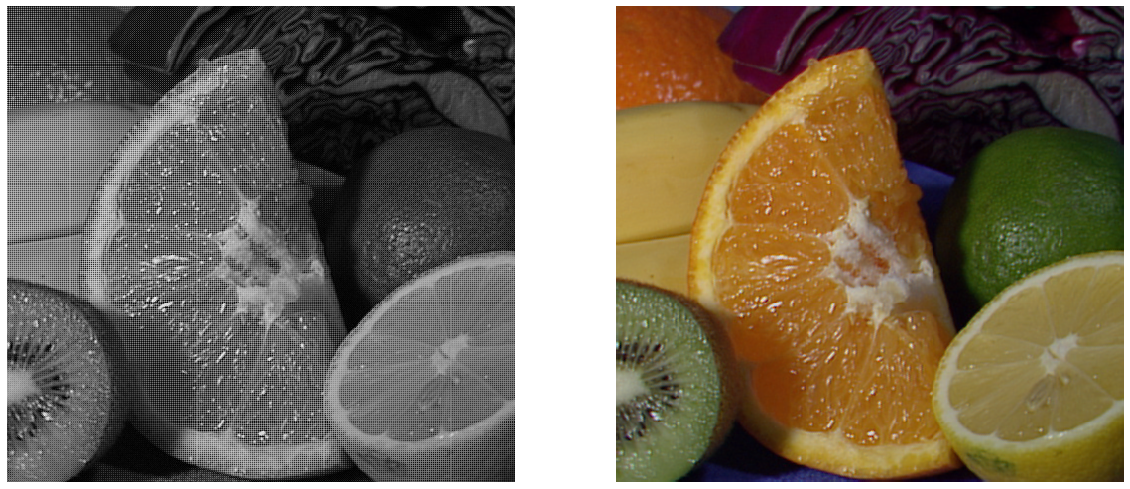

In [31]:
plt.figure(figsize=(20,10))
plt.subplot(121)
plt.imshow(bayer,cmap='gray')
plt.axis('off')
plt.subplot(122)
plt.imshow(debayer)
plt.axis('off');

## Gamma correction
There is a nonlinear relationship between the real intensity and the brightness what we perceive.

In [32]:
brightness, _ = np.meshgrid(np.linspace(0,1,512),range(0,100))

In [33]:
intensity = brightness**2.22

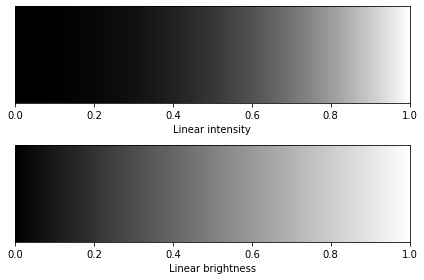

In [34]:
plt.subplot(211)
plt.imshow(intensity,cmap='gray',extent=[0,1,0,1], aspect='auto')
plt.yticks([])
plt.xlabel('Linear intensity')
plt.tight_layout()
plt.subplot(212)
plt.imshow(brightness,cmap='gray',extent=[0,1,0,1], aspect='auto')
plt.yticks([])
plt.xlabel('Linear brightness')
plt.tight_layout();

That is why the images need to be gamma pre-corrected in the camera to make them better suited for the human eye. The next example shows how the image looks like without gamma pre-correction.

In [35]:
before_gamma = (((img/255.0)**2.22)*255.0).astype(np.uint8)

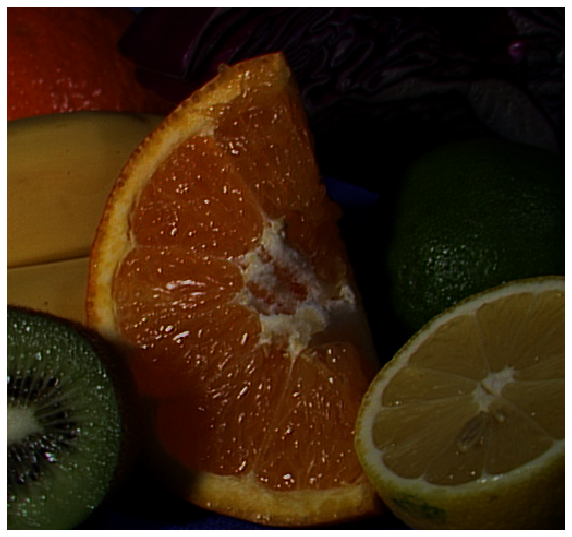

In [36]:
plt.figure(figsize=(10,10))
plt.imshow(before_gamma)
plt.axis('off');

## Image noise
Here we generate two images with realistic shot noise. The first image represents low illumination conditions or short exposure time. In the second image the exposure (= amount of light per unit area) is 10 times higher.

In [37]:
scale = 1.0
image1 = np.zeros((256,256,3), dtype=np.uint8)
for i in range(256):
    image1[:,i,:] = np.clip(np.random.poisson(i*scale,(256,3))/scale, 0, 255).astype(np.uint8)

In [38]:
scale = 10.0
image2 = np.zeros((256,256,3), dtype=np.uint8)
for i in range(256):
    image2[:,i,:] = np.clip(np.random.poisson(i*scale,(256,3))/scale, 0, 255).astype(np.uint8)

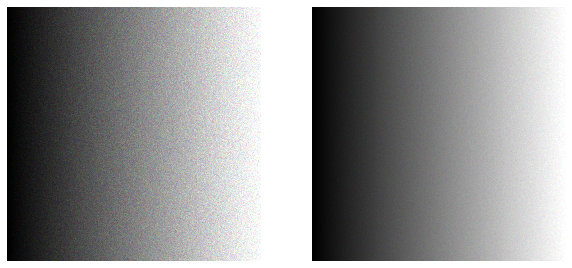

In [39]:
plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(image1)
plt.axis('off')
plt.subplot(122)
plt.imshow(image2)
plt.axis('off');

## White balance
Here we distort the color balance of an image by multiplying the R channel with 0.7 and the B channel with 1.5.

In [40]:
wb = img.copy()
wb[:,:,0] = np.clip(wb[:,:,0]*0.7, 0, 255).astype(np.uint8)
wb[:,:,2] = np.clip(wb[:,:,2]*1.5, 0, 255).astype(np.uint8)

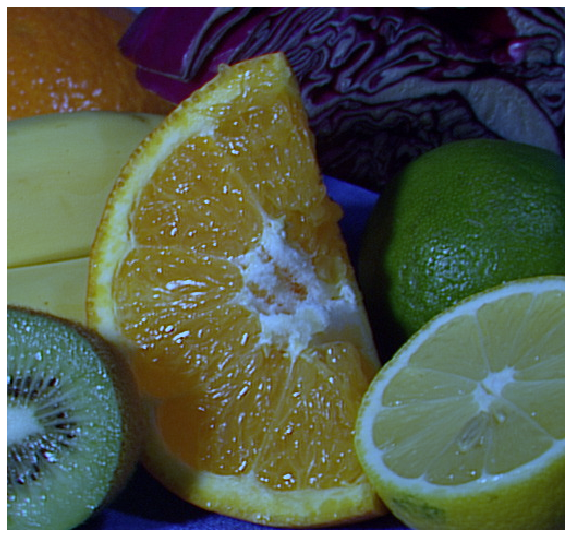

In [41]:
plt.figure(figsize=(10,10))
plt.imshow(wb)
plt.axis('off');